# Problem Statement & Objective

##### Problem: Predict if a customer will churn (Yes/No) based on demographic, account, and service usage features.

##### Objective: Build a reusable ML pipeline that can preprocess data, train models, tune hyperparameters, and be saved for production.

## Imports and Setup

In [2]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Exporting pipeline
import joblib

## Load Dataset

In [5]:
# Load dataset
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


## Convert TotalCharges

In [7]:
# Convert TotalCharges to numeric, coerce errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check how many NaNs were created
print(df['TotalCharges'].isnull().sum())

11


In [10]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

## Convert the target variable

In [11]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

## Split Features and Target

In [12]:
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

## Identify categorical vs numerical columns

In [25]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


## Build Preprocessing Pipeline

In [14]:
# Numerical pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Full preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## Create Complete ML Pipelines

In [15]:
# Logistic Regression Pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

## Train/Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

## Hyperparameter Tuning with GridSearchCV

### Logistic Regression Grid

In [17]:
lr_params = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

lr_grid = GridSearchCV(lr_pipeline, lr_params, cv=5, scoring='roc_auc')
lr_grid.fit(X_train, y_train)

print("Best Logistic Regression Params:", lr_grid.best_params_)

C:\Users\TJ\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\TJ\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\TJ\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in

Best Logistic Regression Params: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


C:\Users\TJ\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


### Random Forest Grid

In [18]:
rf_params = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
}

rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=5, scoring='roc_auc')
rf_grid.fit(X_train, y_train)

print("Best Random Forest Params:", rf_grid.best_params_)

Best Random Forest Params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


## Evaluate Models

In [19]:
# Logistic Regression Evaluation
y_pred_lr = lr_grid.predict(X_test)
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr_grid.predict_proba(X_test)[:,1]))

# Random Forest Evaluation
y_pred_rf = rf_grid.predict(X_test)
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf_grid.predict_proba(X_test)[:,1]))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409

ROC-AUC: 0.8412384716732543
Random Forest Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.53      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

ROC-AUC: 0.8387338861763414


## Confusion Matrix

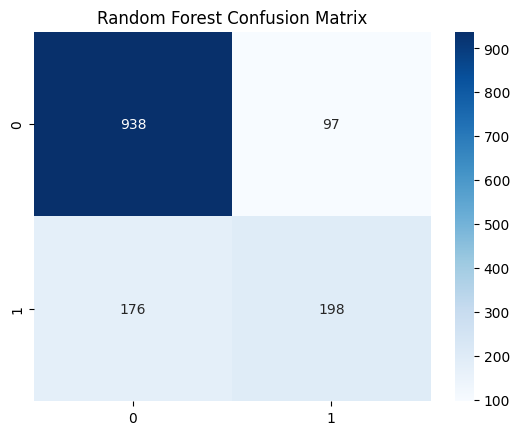

In [20]:
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

## Export the Best Pipeline

In [22]:
# Choose best model based on ROC-AUC
best_pipeline = rf_grid.best_estimator_

# Export to disk
joblib.dump(best_pipeline, 'churn_prediction_pipeline.pkl')
print("Pipeline saved successfully!")

Pipeline saved successfully!


## Summary / Insights